## Access Vessel Satellite Radiance data in Zarr
A jupyter notebook to show how to access and plot the AODN vessel_satellite_radiance_delayed_qc dataset available as [Zarr](https://zarr.dev/) dataset on S3.

More information about the dataset available [here](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/28f8bfed-ca6a-472a-84e4-42563ce4df3f).

In [1]:
dataset_name = "vessel_satellite_radiance_delayed_qc"

In [2]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    import xarray as xr
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 33ms


In [3]:
import requests
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [4]:
from DataQuery import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, \
    get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds

import pandas as pd
import pyarrow.compute as pc

In [5]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [6]:
# only run once, then restart session if needed
!pip install uv

import os
import sys

def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the current directory of the notebook
current_dir = os.getcwd()

# Check if requirements.txt exists in the current directory
local_requirements = os.path.join(current_dir, 'requirements.txt')
if os.path.exists(local_requirements):
    requirements_path = local_requirements
else:
    # Fall back to the online requirements.txt file
    requirements_path = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt'

# Install packages using uv and the determined requirements file
if is_colab():
    xr.set_options(display_style='text')
    os.system(f'uv pip install --system -r {requirements_path}')
else:
    os.system('uv venv')
    os.system(f'uv pip install -r {requirements_path}')

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 234 packages in 34ms


In [7]:
import requests
import os
if not os.path.exists('DataQuery.py'):
  print('Downloading DataQuery.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/DataQuery.py'
  response = requests.get(url)
  with open('DataQuery.py', 'w') as f:
      f.write(response.text)

In [8]:
from DataQuery import plot_gridded_variable, create_timeseries, plot_time_coverage

In [9]:
# remote zarr dataset
url = f's3://aodn-cloud-optimised/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), chunks=None, consolidated=True,decode_times=True, use_cftime=True)

ds

<xarray.Dataset> Size: 118MB
Dimensions:                  (WAVELENGTH_Ed: 200, TIME: 15512,
                              WAVELENGTH_Lsky: 200, WAVELENGTH_Lu: 200)
Coordinates:
    LATITUDE                 (TIME) float64 124kB ...
    LONGITUDE                (TIME) float64 124kB ...
  * TIME                     (TIME) object 124kB 2024-01-28 01:00:01.887041 ....
  * WAVELENGTH_Ed            (WAVELENGTH_Ed) float32 800B 399.3 ... 1.054e+03
  * WAVELENGTH_Lsky          (WAVELENGTH_Lsky) float32 800B 399.3 ... 1.056e+03
  * WAVELENGTH_Lu            (WAVELENGTH_Lu) float32 800B 401.9 ... 1.061e+03
Data variables: (12/16)
    Ed                       (WAVELENGTH_Ed, TIME) float64 25MB ...
    Ed_quality_control       (WAVELENGTH_Ed, TIME) int32 12MB ...
    Lsky                     (WAVELENGTH_Lsky, TIME) float64 25MB ...
    Lsky_quality_control     (WAVELENGTH_Lsky, TIME) int32 12MB ...
    Lu                       (WAVELENGTH_Lu, TIME) float64 25MB ...
    Lu_quality_control       (WAVELENGTH_Lu, TIME) int32 12MB ...
    ...                       ...
    platform_code            (TIME) <U7 434kB ...
    quality_control_version  (TIME) <U49 3MB ...
    relaz                    (TIME) float64 124kB ...
    roll                     (TIME) float64 124kB ...
    rollsd                   (TIME) float64 124kB ...
    sza                      (TIME) float64 124kB ...
Attributes: (12/35)
    Conventions:                   CF-1.6 IMOS-1.4
    Voyage_number:                 8234
    abstract:                      Irradiance and radiance spectra from DALEC...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Lovell, Jenny
    cdm_data_type:                 trajectory
    ...                            ...
    project:                       Integrated Marine Observing System (IMOS)
    source:                        Irradiance and radiance spectra from DALEC...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2024-03-12T04:55:15Z
    time_coverage_start:           2024-03-12T04:02:22Z
    title:                         Calibrated DALEC Transect data

## Plot time coverage

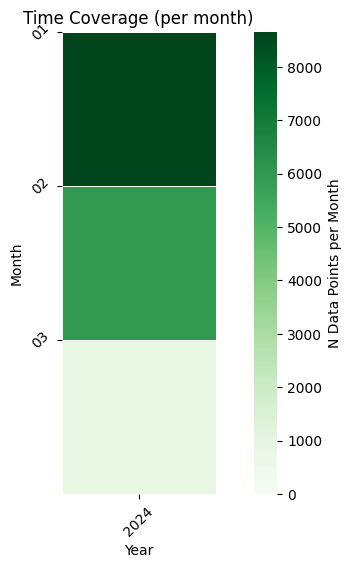

In [10]:
plot_time_coverage(ds, time_var="TIME")

## List unique vessels and filter data accordingly

In [11]:
import numpy as np
np.unique(ds.platform_code.data)

array(['VMQ9273'], dtype='<U7')

In [12]:
import cftime

start = cftime.DatetimeGregorian(2012, 6, 9, 0, 0, 0, has_year_zero=False)
end   = cftime.DatetimeGregorian(2012, 6, 10, 0, 0, 0, has_year_zero=False)

ds_filtered = ds.where(
    (ds.platform_code == 'VLHJ   ') & (ds.TIME >= start) & (ds.TIME < end),
    drop=True
)

ds_filtered.Ed.sortby('TIME').plot()


TypeError: No numeric data to plot.

In [ ]:
np.unique(ds_filtered.quality_control_version)

In [15]:
ds.quality_control_version.data

array(['Level 1 - calibrated radiance and irradiance data',
       'Level 1 - calibrated radiance and irradiance data',
       'Level 1 - calibrated radiance and irradiance data', ...,
       'Level 1 - calibrated radiance and irradiance data',
       'Level 1 - calibrated radiance and irradiance data',
       'Level 1 - calibrated radiance and irradiance data'], dtype='<U49')